In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using Dierckx
using DelimitedFiles

In [3]:
using Revise
using Will

In [4]:
include("utils.jl")
using Revise
using .Utils

### Adapting N5K stuff

In [5]:
z_b = npzread("background/z.npy")
χ = npzread("background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [6]:
pk_dict = npzread("../N5K/input/pk.npz")
Pklin = pk_dict["pk_lin"]
Pknonlin = pk_dict["pk_nl"]
k = pk_dict["k"]
z = pk_dict["z"];

In [7]:
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, x, y)
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [8]:
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm_nl = Interpolations.interpolate(log10.(Pknonlin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm_nl = scale(InterpPmm_nl, x, y)
InterpPmm_nl = Interpolations.extrapolate(InterpPmm_nl, Line());

In [9]:
power_spectrum(k, χ1, χ2) = @. sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)));

In [10]:
power_spectrum_nl(k, χ1, χ2) = @. sqrt(10^InterpPmm_nl(z_of_χ(χ1),log10(k)) * 10^InterpPmm_nl(z_of_χ(χ2),log10(k)));

### Loading N5K stuff

In [11]:
#N5K Cℓ's 
benchmark_gg = npzread("../N5K/tests/benchmarks_nl_full_clgg.npz")
benchmark_ll = npzread("../N5K/tests/benchmarks_nl_full_clss.npz")
benchmark_gl = npzread("../N5K/tests/benchmarks_nl_full_clgs.npz");

In [12]:
gg = benchmark_gg["cls"]
ll = benchmark_ll["cls"]
gl = benchmark_gl["cls"]
ell = benchmark_gg["ls"];

In [13]:
gg_reshaped = zeros(length(ell), 10, 10)
counter = 1

for i in 1:10
    for j in i:10
        gg_reshaped[:,i,j] = gg[counter, :]
        gg_reshaped[:,j,i] = gg_reshaped[:,i,j]
        counter += 1
    end
end

In [14]:
ll_reshaped = zeros(length(ell), 5, 5)
counter = 1

for i in 1:5
    for j in i:5
        ll_reshaped[:,i,j] = ll[counter, :]
        ll_reshaped[:,j,i] = ll_reshaped[:,i,j]
        counter += 1
    end
end

In [15]:
gl_reshaped = zeros(length(ell), 10, 5)
counter = 1

for i in 1:10
    for j in 1:5
        gl_reshaped[:,i,j] = gl[counter, :]
        counter += 1
    end
end

In [16]:
ell = ell[ell .<= 302]
gg_reshaped = gg_reshaped[1:length(ell),:,:]
gl_reshaped = gl_reshaped[1:length(ell),:,:]
ll_reshaped = ll_reshaped[1:length(ell),:,:];

Cosmic Variance
$$\sigma^{AB}_{ij}(\ell) = \sqrt{\frac{(C^{AA}_{ii}(\ell)+N_{ii}^{AA})(C^{BB}_{jj}(\ell)+N_{jj}^{BB}) + (C^{AB}_{ij}(\ell))^2}{f_{sky}(2 \ell +1)}}$$

$$MAER_{ij}^{AB}(\ell) = \frac{|C_{ij,Cheb}^{AB}(\ell) - C_{ij,GT}^{AB}(\ell)|}{\sigma^{AB}_{ij}(\ell)}$$

### Loading my $w_\ell$'s

In [17]:
kmax = 200/13 
kmin = 2.5/7000
n_cheb = 128
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
nχ = 100
χ = LinRange(26, 7000, nχ)
ℓ = npzread("ell_vector.npy")[1:21];

In [18]:
gg_interp = zeros(21,10,10)
ll_interp = zeros(21,5,5)
gl_interp = zeros(21,10,5)

for i in 1:10
    for j in i:10
        interpol = AkimaInterpolation(gg_reshaped[:,i,j], ell)
        gg_interp[:,i,j] = interpol.(ℓ)
        gg_interp[:,j,i] = gg_interp[:,i,j]
    end
end

for i in 1:5
    for j in i:5
        interpol = AkimaInterpolation(ll_reshaped[:,i,j], ell)
        ll_interp[:,i,j] = interpol.(ℓ)
        ll_interp[:,j,i] = ll_interp[:,i,j]
    end
end

for i in 1:10
    for j in 1:5
        interpol = AkimaInterpolation(gl_reshaped[:,i,j], ell)
        gl_interp[:,i,j] = interpol.(ℓ)
    end
end

#### 300+150

In [19]:
R_A = unique(vcat(LinRange(0,0.9,300)[2:end], LinRange(0.9,1,151)))
nR_A = length(R_A)
coeff_A = zeros(nχ,nR_A,n_cheb+1)

for i in 1:nR_A
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R_A[i]), log10(kmin), log10(kmax)); 
        coeff_A[j,i,:] = c.coefs
    end
end

In [20]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_300+150", nχ, nR_A+1)[:,:,2:end,:]
T_CL = load_Ts("Ts_4_real/T_tilde_CL_300+150", nχ, nR_A+1)[:,:,2:end,:]
T_CC = load_Ts("Ts_4_real/T_tilde_CC_300+150", nχ, nR_A+1)[:,:,2:end,:]


w_LL_A = Will.w_ell_tullio(coeff_A, T_LL)
w_CL_A = Will.w_ell_tullio(coeff_A, T_CL)
w_CC_A = Will.w_ell_tullio(coeff_A, T_CC);

#### 100+150

In [21]:
R_B = unique(vcat(LinRange(0,0.9,101)[2:end], LinRange(0.9,1,151)))
nR_B = length(R_B)
coeff_B = zeros(nχ,nR_B,n_cheb+1)

for i in 1:nR_B
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R_B[i]), log10(kmin), log10(kmax)); 
        coeff_B[j,i,:] = c.coefs
    end
end

In [22]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_100+150", nχ, nR_B)
T_CL = load_Ts("Ts_4_real/T_tilde_CL_100+150", nχ, nR_B)
T_CC = load_Ts("Ts_4_real/T_tilde_CC_100+150", nχ, nR_B)


w_LL_B = Will.w_ell_tullio(coeff_B, T_LL)
w_CL_B = Will.w_ell_tullio(coeff_B, T_CL)
w_CC_B = Will.w_ell_tullio(coeff_B, T_CC);

#### 75+150

In [23]:
R_C = unique(vcat(LinRange(0,0.9,76)[2:end], LinRange(0.9,1,151)))
nR_C = length(R_C)
coeff_C = zeros(nχ,nR_C,n_cheb+1)

for i in 1:nR_C
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R_C[i]), log10(kmin), log10(kmax)); 
        coeff_C[j,i,:] = c.coefs
    end
end

In [24]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_75+150", nχ, nR_C)
T_CL = load_Ts("Ts_4_real/T_tilde_CL_75+150", nχ, nR_C)
T_CC = load_Ts("Ts_4_real/T_tilde_CC_75+150", nχ, nR_C)


w_LL_C = Will.w_ell_tullio(coeff_C, T_LL)
w_CL_C = Will.w_ell_tullio(coeff_C, T_CL)
w_CC_C = Will.w_ell_tullio(coeff_C, T_CC);

#### 100+100

In [25]:
R_D = unique(vcat(LinRange(0,0.9,101)[2:end], LinRange(0.9,1,101)))
nR_D = length(R_D)
coeff_D = zeros(nχ,nR_D,n_cheb+1)

for i in 1:nR_D
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R_D[i]), log10(kmin), log10(kmax)); 
        coeff_D[j,i,:] = c.coefs
    end
end

In [26]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_100+100", nχ, nR_D)
T_CL = load_Ts("Ts_4_real/T_tilde_CL_100+100", nχ, nR_D)
T_CC = load_Ts("Ts_4_real/T_tilde_CC_100+100", nχ, nR_D)


w_LL_D = Will.w_ell_tullio(coeff_D, T_LL)
w_CL_D = Will.w_ell_tullio(coeff_D, T_CL)
w_CC_D = Will.w_ell_tullio(coeff_D, T_CC);

#### 75+75 WITH CUT AT 0.95

In [27]:
R_E = unique(vcat(LinRange(0,0.95,76)[2:end], LinRange(0.95,1,76)))
nR_E = length(R_E)
coeff_E = zeros(nχ,nR_E,n_cheb+1)

for i in 1:nR_E
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R_E[i]), log10(kmin), log10(kmax)); 
        coeff_E[j,i,:] = c.coefs
    end
end

In [28]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_75+75", nχ, nR_E)
T_CL = load_Ts("Ts_4_real/T_tilde_CL_75+75", nχ, nR_E)
T_CC = load_Ts("Ts_4_real/T_tilde_CC_75+75", nχ, nR_E)


w_LL_E = Will.w_ell_tullio(coeff_E, T_LL)
w_CL_E = Will.w_ell_tullio(coeff_E, T_CL)
w_CC_E = Will.w_ell_tullio(coeff_E, T_CC);

#### χ200 

In [29]:
R_F = unique(vcat(LinRange(0,0.9,151)[2:end], LinRange(0.9,1,150)))
nR_F = length(R_F)
coeff_F = zeros(200,nR_F,n_cheb+1)
χ_200 = LinRange(26,7000,200)

for i in 1:nR_F
    for j in 1:200
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ_200[j],χ_200[j]*R_F[i]), log10(kmin), log10(kmax)); 
        coeff_F[j,i,:] = c.coefs
    end
end

In [30]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_chi200", 200, nR_F)
T_CL = load_Ts("Ts_4_real/T_tilde_CL_chi200", 200, nR_F)
T_CC = load_Ts("Ts_4_real/T_tilde_CC_chi200", 200, nR_F)


w_LL_F = Will.w_ell_tullio(coeff_F, T_LL)
w_CL_F = Will.w_ell_tullio(coeff_F, T_CL);
w_CC_F = Will.w_ell_tullio(coeff_F, T_CC);

#### 75+450, α=0.8

In [32]:
R_G = unique(vcat(LinRange(0,0.8,76)[2:end], LinRange(0.8,1,451)))
nR_G = length(R_G)
coeff_G = zeros(100,nR_G,n_cheb+1)

for i in 1:nR_G
    for j in 1:100
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R_G[i]), log10(kmin), log10(kmax)); 
        coeff_G[j,i,:] = c.coefs
    end
end

In [33]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_75+450", 100, nR_G)
T_CL = load_Ts("Ts_4_real/T_tilde_CL_75+450", 100, nR_G)
T_CC = load_Ts("Ts_4_real/T_tilde_CC_75+450", 100, nR_G)


w_LL_G = Will.w_ell_tullio(coeff_G, T_LL)
w_CL_G = Will.w_ell_tullio(coeff_G, T_CL);
w_CC_G = Will.w_ell_tullio(coeff_G, T_CC);

### Limber functions!!

# $C_\ell$'s computation

In [34]:
Cℓ_CC_limb = npzread("Cl_CC_limber_linear.npy")
Cℓ_CL_limb = npzread("Cl_CL_limber_linear.npy")
Cℓ_LL_limb = npzread("Cl_LL_limber_linear.npy");

In [35]:
Cℓ_CC_limb_nl = npzread("Cl_CC_limber_nl.npy")
Cℓ_CL_limb_nl = npzread("Cl_CL_limber_nl.npy")
Cℓ_LL_limb_nl = npzread("Cl_LL_limber_nl.npy");

In [37]:
W = npzread("../N5K/input/kernels_fullwidth.npz")
@time K_CC_A, K_CL_A, K_LL_A = compute_kernels(W, χ, R_A)
@time K_CC_B, K_CL_B, K_LL_B = compute_kernels(W, χ, R_B)
@time K_CC_C, K_CL_C, K_LL_C = compute_kernels(W, χ, R_C)
@time K_CC_D, K_CL_D, K_LL_D = compute_kernels(W, χ, R_D)
@time K_CC_E, K_CL_E, K_LL_E = compute_kernels(W, χ, R_E)
@time K_CC_F, K_CL_F, K_LL_F = compute_kernels(W, χ_200, R_F);
@time K_CC_G, K_CL_G, K_LL_G = compute_kernels(W, χ, R_G);

  0.117185 seconds (860 allocations: 83.407 MiB, 53.28% gc time)
  0.023703 seconds (789 allocations: 48.937 MiB)
  0.021045 seconds (789 allocations: 44.609 MiB)
  0.019031 seconds (783 allocations: 40.277 MiB)
  0.014667 seconds (731 allocations: 31.615 MiB)
  0.055608 seconds (880 allocations: 109.224 MiB)
  0.049188 seconds (1.01 k allocations: 96.581 MiB)


In [38]:
@time σ_CC, σ_LL, σ_CL = cosmic_variance(gg_interp, ll_interp, gl_interp, ℓ, 0.4);

┌ Warning: #= /Users/sofiachiarenza/.julia/packages/Tullio/vChiX/src/macro.jl:1093 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ Main.Utils ~/.julia/packages/LoopVectorization/7gWfp/src/condense_loopset.jl:1148
┌ Warning: #= /Users/sofiachiarenza/.julia/packages/Tullio/vChiX/src/macro.jl:1093 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ Main.Utils ~/.julia/packages/LoopVectorization/7gWfp/src/condense_loopset.jl:1148


  2.280150 seconds (6.94 M allocations: 1.136 GiB, 6.30% gc time, 99.85% compilation time)


┌ Warning: #= /Users/sofiachiarenza/.julia/packages/Tullio/vChiX/src/macro.jl:1093 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ Main.Utils ~/.julia/packages/LoopVectorization/7gWfp/src/condense_loopset.jl:1148


#### 300+150

In [39]:
Cℓ_CC_A = C_ell_computation_simpson_uneven_grid(w_CC_A, K_CC_A, 299, 150,0.9);
Cℓ_CL_A = C_ell_computation_simpson_uneven_grid(w_CL_A, K_CL_A, 299, 150,0.9);
Cℓ_LL_A = C_ell_computation_simpson_uneven_grid(w_LL_A, K_LL_A, 299, 150,0.9);

In [40]:
# ADDING ELL PREFACTORS
Cℓ_CC_A = Cℓ_CC_A .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_A[i,:,:] = Cℓ_LL_A[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_A[i,:,:] = Cℓ_CL_A[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [41]:
final_Cℓ_CC_A = Cℓ_CC_A + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL_A = Cℓ_CL_A + Cℓ_CL_limb_nl - Cℓ_CL_limb
final_Cℓ_LL_A = Cℓ_LL_A + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In [42]:
@time begin 
    m_CC_A = MAER(final_Cℓ_CC_A, gg_interp, σ_CC)
    m_LL_A = MAER(final_Cℓ_LL_A, ll_interp, σ_LL)
    m_CL_A = MAER(final_Cℓ_CL_A, gl_interp, σ_CL)
end;

  0.509259 seconds (1.54 M allocations: 82.788 MiB, 1.62% gc time, 99.99% compilation time)


#### 100+150

In [43]:
@time Cℓ_CC_B = C_ell_computation_simpson_uneven_grid(w_CC_B, K_CC_B, 100, 150,0.9);
@time Cℓ_CL_B = C_ell_computation_simpson_uneven_grid(w_CL_B, K_CL_B, 100, 150,0.9);
@time Cℓ_LL_B = C_ell_computation_simpson_uneven_grid(w_LL_B, K_LL_B, 100, 150,0.9);

  0.008283 seconds (155 allocations: 45.125 KiB)
  0.003643 seconds (156 allocations: 37.180 KiB)
  0.002525 seconds (156 allocations: 33.188 KiB)


In [44]:
# ADDING ELL PREFACTORS
Cℓ_CC_B = Cℓ_CC_B .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_B[i,:,:] = Cℓ_LL_B[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_B[i,:,:] = Cℓ_CL_B[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [45]:
final_Cℓ_CC_B = Cℓ_CC_B + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL_B = Cℓ_CL_B + Cℓ_CL_limb_nl - Cℓ_CL_limb
final_Cℓ_LL_B = Cℓ_LL_B + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In [46]:
@time begin 
    m_CC_B = MAER(final_Cℓ_CC_B, gg_interp, σ_CC)
    m_LL_B = MAER(final_Cℓ_LL_B, ll_interp, σ_LL)
    m_CL_B = MAER(final_Cℓ_CL_B, gl_interp, σ_CL)
end;

  0.000025 seconds (4 allocations: 29.125 KiB)


#### 75+150

In [47]:
Cℓ_CC_C = C_ell_computation_simpson_uneven_grid(w_CC_C, K_CC_C, 75, 150,0.9);
Cℓ_CL_C = C_ell_computation_simpson_uneven_grid(w_CL_C, K_CL_C, 75, 150,0.9);
Cℓ_LL_C = C_ell_computation_simpson_uneven_grid(w_LL_C, K_LL_C, 75, 150,0.9);

In [48]:
# ADDING ELL PREFACTORS
Cℓ_CC_C = Cℓ_CC_C .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_C[i,:,:] = Cℓ_LL_C[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_C[i,:,:] = Cℓ_CL_C[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [49]:
final_Cℓ_CC_C = Cℓ_CC_C + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL_C = Cℓ_CL_C + Cℓ_CL_limb_nl - Cℓ_CL_limb
final_Cℓ_LL_C = Cℓ_LL_C + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In [50]:
@time begin 
    m_CC_C = MAER(final_Cℓ_CC_C, gg_interp, σ_CC)
    m_LL_C = MAER(final_Cℓ_LL_C, ll_interp, σ_LL)
    m_CL_C = MAER(final_Cℓ_CL_C, gl_interp, σ_CL)
end;

  0.000019 seconds (4 allocations: 29.125 KiB)


#### 100+100

In [51]:
Cℓ_CC_D = C_ell_computation_simpson_uneven_grid(w_CC_D, K_CC_D, 100, 100,0.9);
Cℓ_CL_D = C_ell_computation_simpson_uneven_grid(w_CL_D, K_CL_D, 100, 100,0.9);
Cℓ_LL_D = C_ell_computation_simpson_uneven_grid(w_LL_D, K_LL_D, 100, 100,0.9);

In [52]:
# ADDING ELL PREFACTORS
Cℓ_CC_D = Cℓ_CC_D .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_D[i,:,:] = Cℓ_LL_D[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_D[i,:,:] = Cℓ_CL_D[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [53]:
final_Cℓ_CC_D = Cℓ_CC_D + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL_D = Cℓ_CL_D + Cℓ_CL_limb_nl - Cℓ_CL_limb
final_Cℓ_LL_D = Cℓ_LL_D + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In [54]:
@time begin 
    m_CC_D = MAER(final_Cℓ_CC_D, gg_interp, σ_CC)
    m_LL_D = MAER(final_Cℓ_LL_D, ll_interp, σ_LL)
    m_CL_D = MAER(final_Cℓ_CL_D, gl_interp, σ_CL)
end;

  0.000025 seconds (4 allocations: 29.125 KiB)


#### 75+75

In [55]:
Cℓ_CC_E = C_ell_computation_simpson_uneven_grid(w_CC_E, K_CC_E, 75, 75, 0.95);
Cℓ_CL_E = C_ell_computation_simpson_uneven_grid(w_CL_E, K_CL_E, 75, 75, 0.95);
Cℓ_LL_E = C_ell_computation_simpson_uneven_grid(w_LL_E, K_LL_E, 75, 75, 0.95);

In [56]:
# ADDING ELL PREFACTORS
Cℓ_CC_E = Cℓ_CC_E .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_E[i,:,:] = Cℓ_LL_E[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_E[i,:,:] = Cℓ_CL_E[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [57]:
final_Cℓ_CC_E = Cℓ_CC_E + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL_E = Cℓ_CL_E + Cℓ_CL_limb_nl - Cℓ_CL_limb
final_Cℓ_LL_E = Cℓ_LL_E + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In [58]:
@time begin 
    m_CC_E = MAER(final_Cℓ_CC_E, gg_interp, σ_CC)
    m_LL_E = MAER(final_Cℓ_LL_E, ll_interp, σ_LL)
    m_CL_E = MAER(final_Cℓ_CL_E, gl_interp, σ_CL)
end;

  0.000022 seconds (4 allocations: 29.125 KiB)


#### χ 200

In [59]:
Cℓ_CC_F = C_ell_computation_simpson_uneven_grid(w_CC_F, K_CC_F, 150, 149, 0.9);
Cℓ_CL_F = C_ell_computation_simpson_uneven_grid(w_CL_F, K_CL_F, 150, 149, 0.9);
Cℓ_LL_F = C_ell_computation_simpson_uneven_grid(w_LL_F, K_LL_F, 150, 149, 0.9);

In [60]:
# ADDING ELL PREFACTORS
Cℓ_CC_F = Cℓ_CC_F .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_F[i,:,:] = Cℓ_LL_F[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_F[i,:,:] = Cℓ_CL_F[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [61]:
final_Cℓ_CC_F = Cℓ_CC_F + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL_F = Cℓ_CL_F + Cℓ_CL_limb_nl - Cℓ_CL_limb;
final_Cℓ_LL_F = Cℓ_LL_F + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In [62]:
@time begin 
    m_CC_F = MAER(final_Cℓ_CC_F, gg_interp, σ_CC)
    m_LL_F = MAER(final_Cℓ_LL_F, ll_interp, σ_LL)
    m_CL_F = MAER(final_Cℓ_CL_F, gl_interp, σ_CL)
end;

  0.000030 seconds (4 allocations: 29.125 KiB)


#### 75+450, α=0.8

In [63]:
Cℓ_CC_G = C_ell_computation_simpson_uneven_grid(w_CC_G, K_CC_G, 75, 450, 0.8);
Cℓ_CL_G = C_ell_computation_simpson_uneven_grid(w_CL_G, K_CL_G, 75, 450, 0.8);
Cℓ_LL_G = C_ell_computation_simpson_uneven_grid(w_LL_G, K_LL_G, 75, 450, 0.8);

In [64]:
# ADDING ELL PREFACTORS
Cℓ_CC_G = Cℓ_CC_G .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_G[i,:,:] = Cℓ_LL_G[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_G[i,:,:] = Cℓ_CL_G[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [65]:
final_Cℓ_CC_G = Cℓ_CC_G + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL_G = Cℓ_CL_G + Cℓ_CL_limb_nl - Cℓ_CL_limb;
final_Cℓ_LL_G = Cℓ_LL_G + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In [66]:
@time begin 
    m_CC_G = MAER(final_Cℓ_CC_G, gg_interp, σ_CC)
    m_LL_G = MAER(final_Cℓ_LL_G, ll_interp, σ_LL)
    m_CL_G = MAER(final_Cℓ_CL_G, gl_interp, σ_CL)
end;

  0.000024 seconds (4 allocations: 29.125 KiB)


# Plots 

## CC

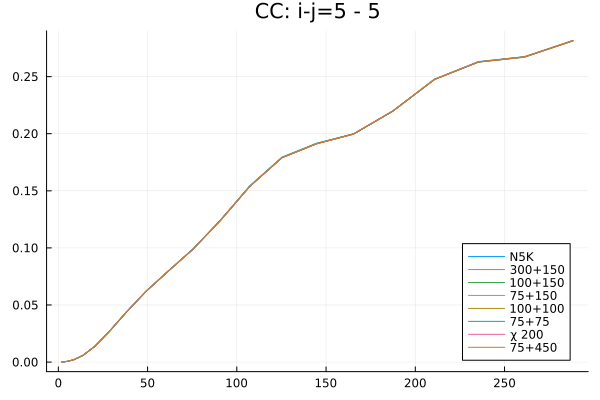

In [67]:
i = 5
j = 5
plot(ℓ, gg_interp[:,i,j] .* ℓ .* (ℓ .+ 1), title = "CC: i-j=$i - $j", label="N5K")#, xlim=(2,302)), xscale=:log10)
plot!(ℓ, final_Cℓ_CC_A[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "300+150")
plot!(ℓ, final_Cℓ_CC_B[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+150")
plot!(ℓ, final_Cℓ_CC_C[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75+150")
plot!(ℓ, final_Cℓ_CC_D[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+100")
plot!(ℓ, final_Cℓ_CC_E[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75+75", legend=:bottomright)
plot!(ℓ, final_Cℓ_CC_F[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "χ 200")
plot!(ℓ, final_Cℓ_CC_G[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75+450")

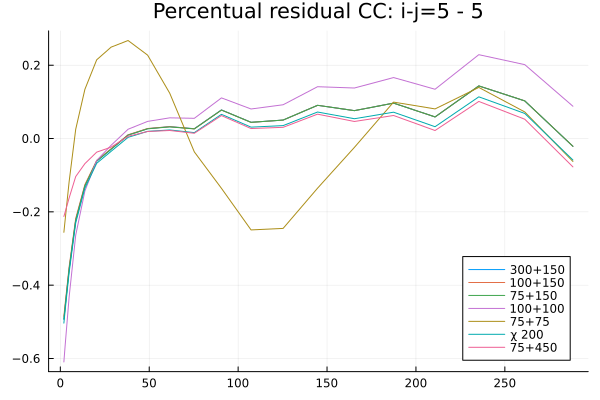

In [68]:
plot(ℓ, 100*(1 .- final_Cℓ_CC_A[:,i,j]./gg_interp[:,i,j]), label="300+150", title = "Percentual residual CC: i-j=$i - $j")
plot!(ℓ, 100*(1 .- final_Cℓ_CC_B[:,i,j]./gg_interp[:,i,j]), label="100+150")
plot!(ℓ, 100*(1 .- final_Cℓ_CC_C[:,i,j]./gg_interp[:,i,j]), label="75+150")
plot!(ℓ, 100*(1 .- final_Cℓ_CC_D[:,i,j]./gg_interp[:,i,j]), label="100+100")
plot!(ℓ, 100*(1 .- final_Cℓ_CC_E[:,i,j]./gg_interp[:,i,j]), label="75+75")
plot!(ℓ, 100*(1 .- final_Cℓ_CC_F[:,i,j]./gg_interp[:,i,j]), label="χ 200")
plot!(ℓ, 100*(1 .- final_Cℓ_CC_G[:,i,j]./gg_interp[:,i,j]), label="75+450")
#plot!(ℓ, 100*(1 .- final_Cℓ_CC_B[:,i,j]./final_Cℓ_CC_A[:,i,j]), label="A-B")

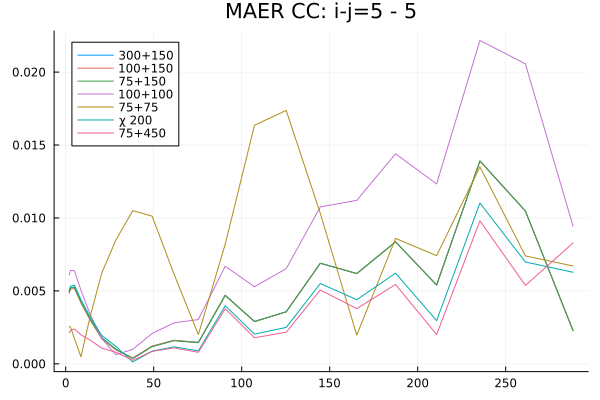

In [69]:
plot(ℓ, m_CC_A[:,i,j], label="300+150", title = "MAER CC: i-j=$i - $j")
plot!(ℓ, m_CC_B[:,i,j], label="100+150")
plot!(ℓ, m_CC_C[:,i,j], label="75+150")
plot!(ℓ, m_CC_D[:,i,j], label="100+100")
plot!(ℓ, m_CC_E[:,i,j], label="75+75")
plot!(ℓ, m_CC_F[:,i,j], label="χ 200")
plot!(ℓ, m_CC_G[:,i,j], label="75+450")

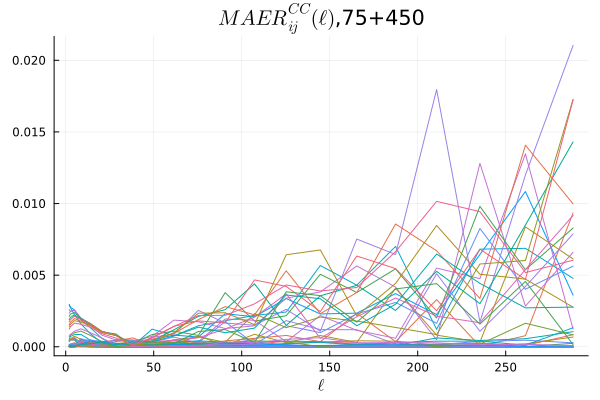

In [70]:
p = plot(title=L"$MAER_{ij}^{CC}(\ell)$,75+450", xlabel=L"\ell")
for i in 1:10
    for j in i:10
        plot!(p, ℓ, m_CC_G[:,i,j], label= nothing)
    end
end
p

## LL

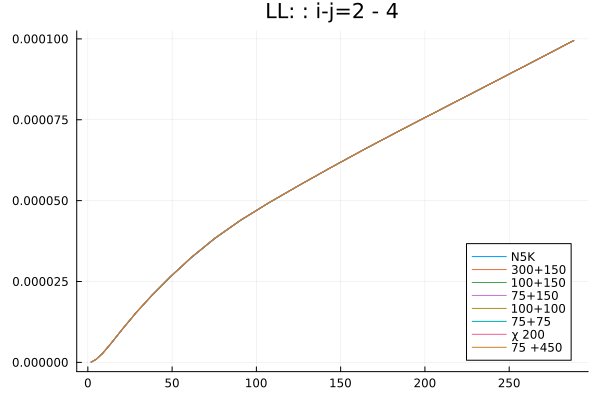

In [71]:
i = 2
j = 4
plot(ℓ, ll_interp[:,i,j] .* ℓ .* (ℓ .+ 1), title = "LL: : i-j=$i - $j", label="N5K")#, xlim=(2,302),ylim=(0,0.0001))
plot!(ℓ, final_Cℓ_LL_A[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "300+150")
plot!(ℓ, final_Cℓ_LL_B[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+150")
plot!(ℓ, final_Cℓ_LL_C[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75+150")
plot!(ℓ, final_Cℓ_LL_D[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+100",legend=:bottomright)
plot!(ℓ, final_Cℓ_LL_E[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75+75")
plot!(ℓ, final_Cℓ_LL_F[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "χ 200")
plot!(ℓ, final_Cℓ_LL_G[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75 +450")

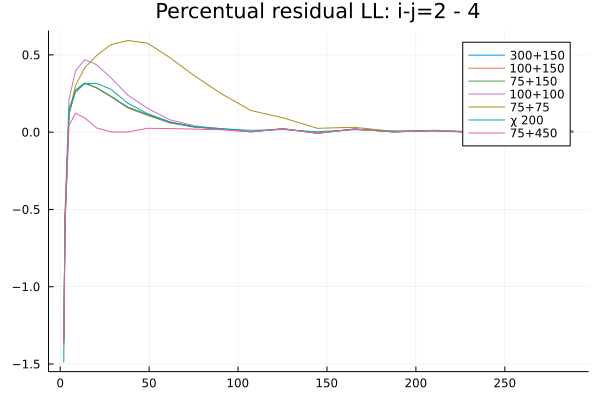

In [72]:
plot(ℓ, 100*(1 .- final_Cℓ_LL_A[:,i,j]./ll_interp[:,i,j]), label="300+150",title = "Percentual residual LL: i-j=$i - $j")
plot!(ℓ, 100*(1 .- final_Cℓ_LL_B[:,i,j]./ll_interp[:,i,j]), label="100+150")
plot!(ℓ, 100*(1 .- final_Cℓ_LL_C[:,i,j]./ll_interp[:,i,j]), label="75+150")
plot!(ℓ, 100*(1 .- final_Cℓ_LL_D[:,i,j]./ll_interp[:,i,j]), label="100+100")
plot!(ℓ, 100*(1 .- final_Cℓ_LL_E[:,i,j]./ll_interp[:,i,j]), label="75+75")
plot!(ℓ, 100*(1 .- final_Cℓ_LL_F[:,i,j]./ll_interp[:,i,j]), label="χ 200")
plot!(ℓ, 100*(1 .- final_Cℓ_LL_G[:,i,j]./ll_interp[:,i,j]), label="75+450")
#plot!(ℓ, 100*(1 .- final_Cℓ_LL_B[:,i,j]./final_Cℓ_LL_A[:,i,j]), label="A-B")

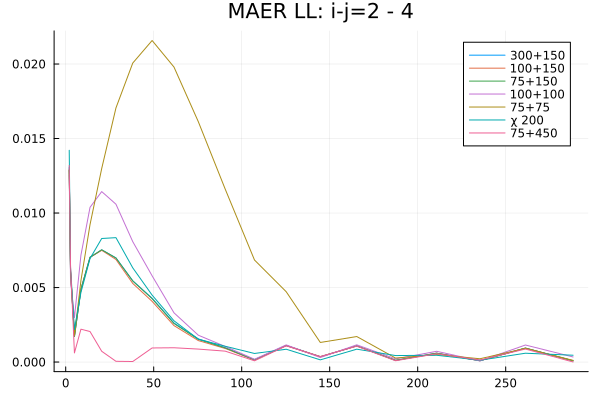

In [73]:
plot(ℓ, m_LL_A[:,i,j], label="300+150", title = "MAER LL: i-j=$i - $j")
plot!(ℓ, m_LL_B[:,i,j], label="100+150")
plot!(ℓ, m_LL_C[:,i,j], label="75+150")
plot!(ℓ, m_LL_D[:,i,j], label="100+100")
plot!(ℓ, m_LL_E[:,i,j], label="75+75")
plot!(ℓ, m_LL_F[:,i,j], label="χ 200")
plot!(ℓ, m_LL_G[:,i,j], label="75+450")

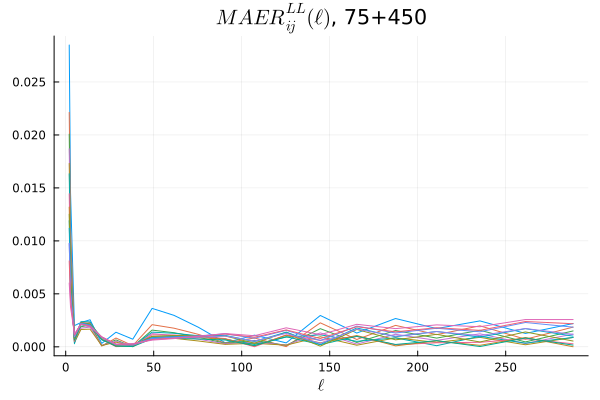

In [74]:
p = plot(title=L"$MAER_{ij}^{LL}(\ell)$, 75+450", xlabel=L"\ell")
for i in 1:5
    for j in i:5
        plot!(p, ℓ, m_LL_G[:,i,j], label= nothing)
    end
end
p

## CL

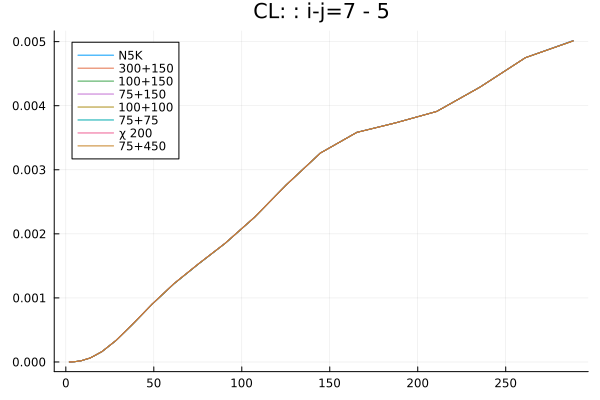

In [75]:
i = 7
j = 5
plot(ℓ, gl_interp[:,i,j] .* ℓ .* (ℓ .+ 1), title = "CL: : i-j=$i - $j", label="N5K")#, xlim=(2,302),ylim=(0,0.002))#, yscale=:log10)
plot!(ℓ, final_Cℓ_CL_A[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "300+150")
plot!(ℓ, final_Cℓ_CL_B[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+150")
plot!(ℓ, final_Cℓ_CL_C[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75+150")
plot!(ℓ, final_Cℓ_CL_D[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+100")
plot!(ℓ, final_Cℓ_CL_E[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75+75")
plot!(ℓ, final_Cℓ_CL_F[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "χ 200")
plot!(ℓ, final_Cℓ_CL_G[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75+450")

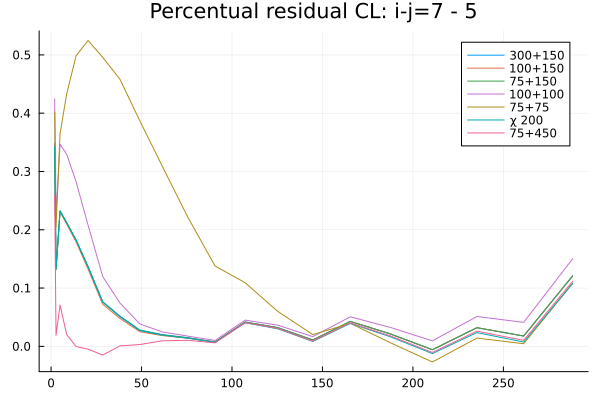

In [76]:
plot(ℓ, 100*(1 .- final_Cℓ_CL_A[:,i,j]./gl_interp[:,i,j]), label="300+150",title = "Percentual residual CL: i-j=$i - $j")
plot!(ℓ, 100*(1 .- final_Cℓ_CL_B[:,i,j]./gl_interp[:,i,j]), label="100+150")
plot!(ℓ, 100*(1 .- final_Cℓ_CL_C[:,i,j]./gl_interp[:,i,j]), label="75+150")
plot!(ℓ, 100*(1 .- final_Cℓ_CL_D[:,i,j]./gl_interp[:,i,j]), label="100+100")
plot!(ℓ, 100*(1 .- final_Cℓ_CL_E[:,i,j]./gl_interp[:,i,j]), label="75+75")
plot!(ℓ, 100*(1 .- final_Cℓ_CL_F[:,i,j]./gl_interp[:,i,j]), label="χ 200")
plot!(ℓ, 100*(1 .- final_Cℓ_CL_G[:,i,j]./gl_interp[:,i,j]), label="75+450")
#plot!(ℓ, 100*(1 .- final_Cℓ_CL_B[:,i,j]./final_Cℓ_CL_A[:,i,j]), label="A-B")

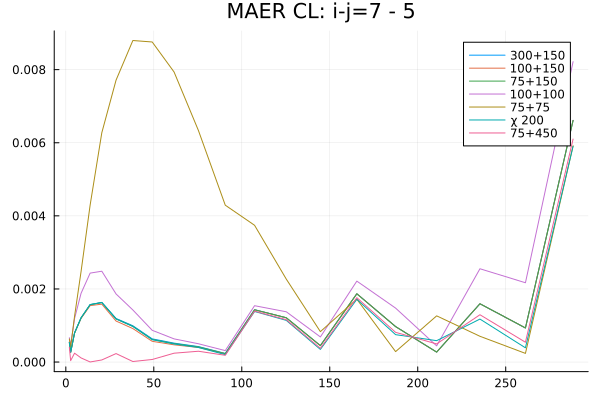

In [77]:
plot(ℓ, m_CL_A[:,i,j], label="300+150", title = "MAER CL: i-j=$i - $j")
plot!(ℓ, m_CL_B[:,i,j], label="100+150")
plot!(ℓ, m_CL_C[:,i,j], label="75+150")
plot!(ℓ, m_CL_D[:,i,j], label="100+100")
plot!(ℓ, m_CL_E[:,i,j], label="75+75")
plot!(ℓ, m_CL_F[:,i,j], label="χ 200")
plot!(ℓ, m_CL_G[:,i,j], label="75+450")

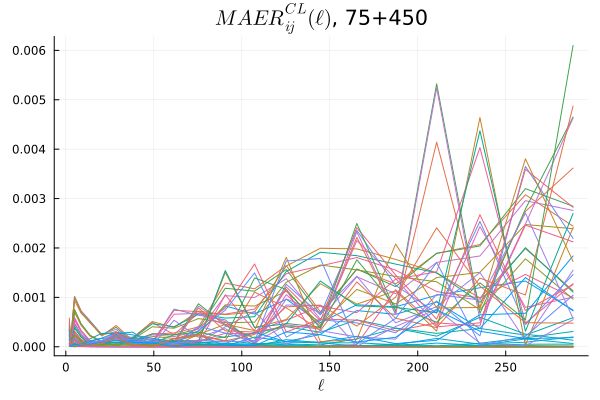

In [78]:
p = plot(title=L"$MAER_{ij}^{CL}(\ell)$, 75+450", xlabel=L"\ell")
for i in 1:10
    for j in 1:5
        plot!(p, ℓ, m_CL_G[:,i,j], label= nothing)
    end
end
p

# Float32 test

In [79]:
w_LL_G_32 = Float32.(w_LL_G)
w_CL_G_32 = Float32.(w_CL_G)
w_CC_G_32 = Float32.(w_CC_G);

In [80]:
K_CC_G_32, K_CL_G_32, K_LL_G_32 = Float32.(K_CC_G), Float32.(K_CL_G), Float32.(K_LL_G);

In [81]:
@time Cℓ_CC_G_32 = C_ell_computation_simpson_uneven_grid(w_CC_G_32, K_CC_G_32, 75, 450, 0.8);
@time Cℓ_CL_G_32 = C_ell_computation_simpson_uneven_grid(w_CL_G_32, K_CL_G_32, 75, 450, 0.8);
@time Cℓ_LL_G_32 = C_ell_computation_simpson_uneven_grid(w_LL_G_32, K_LL_G_32, 75, 450, 0.8);

  4.804009 seconds (13.12 M allocations: 2.233 GiB, 12.07% gc time, 100.00% compilation time)
  0.004230 seconds (156 allocations: 35.031 KiB)
  0.002175 seconds (156 allocations: 33.219 KiB)


In [82]:
# ADDING ELL PREFACTORS
Cℓ_CC_G_32 = Cℓ_CC_G_32 .* Float32((2/π))

for i in 1:length(ℓ)
    Cℓ_LL_G_32[i,:,:] = Cℓ_LL_G_32[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_G_32[i,:,:] = Cℓ_CL_G_32[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [83]:
final_Cℓ_CC_G_32 = Cℓ_CC_G_32 + Float32.(Cℓ_CC_limb_nl) - Float32.(Cℓ_CC_limb)
final_Cℓ_CL_G_32 = Cℓ_CL_G_32 + Float32.(Cℓ_CL_limb_nl) - Float32.(Cℓ_CL_limb)
final_Cℓ_LL_G_32 = Cℓ_LL_G_32 + Float32.(Cℓ_LL_limb_nl) - Float32.(Cℓ_LL_limb);

In [85]:
σ_CC_32, σ_LL_32, σ_CL_32 = Float32.(σ_CC), Float32.(σ_LL), Float32.(σ_CL);

In [86]:
@time begin 
    m_CC_G_32 = MAER(final_Cℓ_CC_G_32, Float32.(gg_interp), σ_CC_32)
    m_LL_G_32 = MAER(final_Cℓ_LL_G_32, Float32.(ll_interp), σ_LL_32)
    m_CL_G_32 = MAER(final_Cℓ_CL_G_32, Float32.(gl_interp), σ_CL_32)
end;

  0.503190 seconds (1.39 M allocations: 72.594 MiB, 3.20% gc time, 99.99% compilation time)


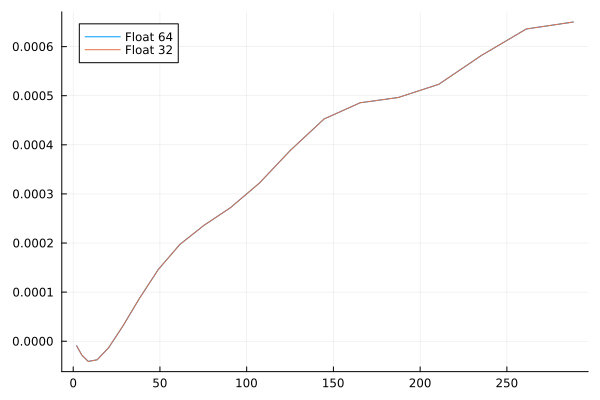

In [90]:
i = 8
j = 5
plot(ℓ, final_Cℓ_CC_G[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "Float 64")
plot!(ℓ, final_Cℓ_CC_G_32[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "Float 32")

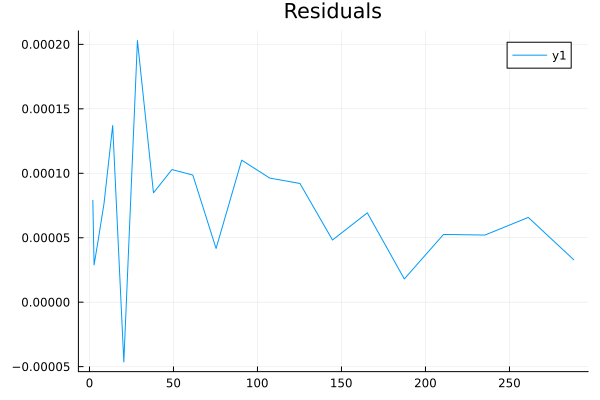

In [91]:
plot(ℓ, 100*(1 .- final_Cℓ_CC_G_32[:,i,j]./final_Cℓ_CC_G[:,i,j]), title = "Residuals")

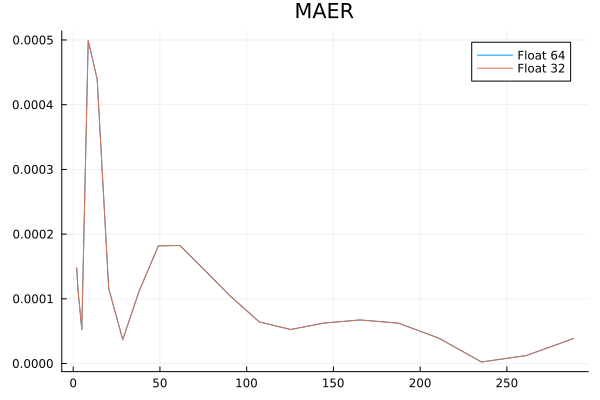

In [92]:
plot(ℓ, m_CC_G[:,i,j], label="Float 64", title="MAER")
plot!(ℓ, m_CC_G_32[:,i,j], label="Float 32")

# Interpolation teststststs

In [91]:
Δχ = ((last(χ)-first(χ))/(nχ-1))
pesi_χ = SimpsonWeightArray(nχ)

@tullio C̃_CC[l,i,j,m] := χ[n]*K_CC_A[i,j,n,m]*w_CC_A[l,n,m]*pesi_χ[n]*Δχ
@tullio C̃_LL[l,i,j,m] := χ[n]*K_LL_A[i,j,n,m]*w_LL_A[l,n,m]*pesi_χ[n]*Δχ
@tullio C̃_CL[l,i,j,m] := χ[n]*K_CL_A[i,j,n,m]*w_CL_A[l,n,m]*pesi_χ[n]*Δχ;

In [92]:
n1 = 50
n2 = 125
α = 0.9
R1 = LinRange(0,α,n1+1)[2:end]
R2 = LinRange(α,1,n2+1)[2:end]
R_interp = unique(vcat(R1, R2))
@time begin C_CC_interp = zeros(length(ℓ), 10, 10, length(R_interp))
for l in 1:21
    for i in 1:10
        for j in i:10
            int = AkimaInterpolation(C̃_CC[l,i,j,:], R_A)
            C_CC_interp[l,i,j,:] = int.(R_interp)
            C_CC_interp[l,j,i,:] = C_CC_interp[l,i,j,:]
        end
    end
end
end

@time begin C_LL_interp = zeros(length(ℓ), 5, 5, length(R_interp))
for l in 1:21
    for i in 1:5
        for j in i:5
            int = AkimaInterpolation(C̃_LL[l,i,j,:], R_A)
            C_LL_interp[l,i,j,:] = int.(R_interp)
            C_LL_interp[l,j,i,:] = C_LL_interp[l,i,j,:]
        end
    end
end
end

@time begin C_CL_interp = zeros(length(ℓ), 10, 5, length(R_interp))
for l in 1:21
    for i in 1:10
        for j in 1:5
            int = AkimaInterpolation(C̃_CL[l,i,j,:], R_A)
            C_CL_interp[l,i,j,:] = int.(R_interp)
        end
    end
end
end

  0.105697 seconds (203.38 k allocations: 130.495 MiB, 22.73% gc time, 40.63% compilation time)
  0.013462 seconds (32.45 k allocations: 36.966 MiB, 21.67% gc time)
  0.035479 seconds (73.50 k allocations: 112.101 MiB, 15.72% gc time)


In [93]:
ΔR1 = ((last(R1)-first(R1))/(length(R1)-1))
pesi_R1 = SimpsonWeightArray(length(R1))
ΔR2 = ((last(R2)-first(R2))/(length(R2)-1))
pesi_R2 = SimpsonWeightArray(length(R2))

a = ones(length(R1))*ΔR1 
b = ones(length(R2))*ΔR2 
ΔR = vcat(a,b)
pesi_R = vcat(pesi_R1,pesi_R2)

@tullio Cℓ_CC_interpolated[l,i,j] := C_CC_interp[l,i,j,m]*pesi_R[m]*ΔR[m];
@tullio Cℓ_CL_interpolated[l,i,j] := C_CL_interp[l,i,j,m]*pesi_R[m]*ΔR[m];
@tullio Cℓ_LL_interpolated[l,i,j] := C_LL_interp[l,i,j,m]*pesi_R[m]*ΔR[m];

In [94]:
Cℓ_CC_interpolated = Cℓ_CC_interpolated .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_interpolated[i,:,:] = Cℓ_LL_interpolated[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_interpolated[i,:,:] = Cℓ_CL_interpolated[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [95]:
Cℓ_CC_interpolated = Cℓ_CC_interpolated + Cℓ_CC_limb_nl - Cℓ_CC_limb
Cℓ_LL_interpolated = Cℓ_LL_interpolated + Cℓ_LL_limb_nl - Cℓ_LL_limb
Cℓ_CL_interpolated = Cℓ_CL_interpolated + Cℓ_CL_limb_nl - Cℓ_CL_limb;

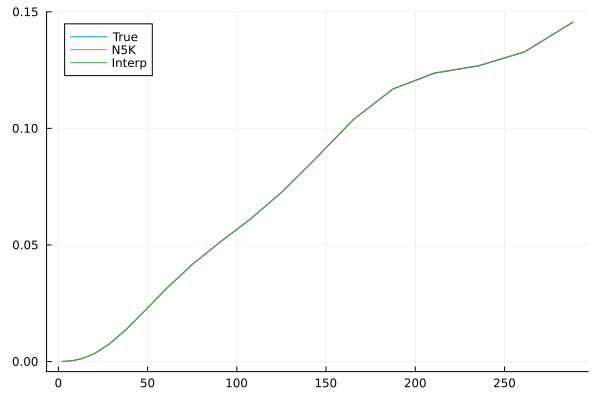

In [96]:
i = 9
j = 10
plot(ℓ, final_Cℓ_CC_B[:,i,j] .* ℓ .* (ℓ.+1), label = "True")
plot!(ℓ, gg_interp[:,i,j] .* ℓ .* (ℓ .+ 1),label="N5K")
plot!(ℓ, Cℓ_CC_interpolated[:,i,j] .* ℓ .* (ℓ.+1), label = "Interp")

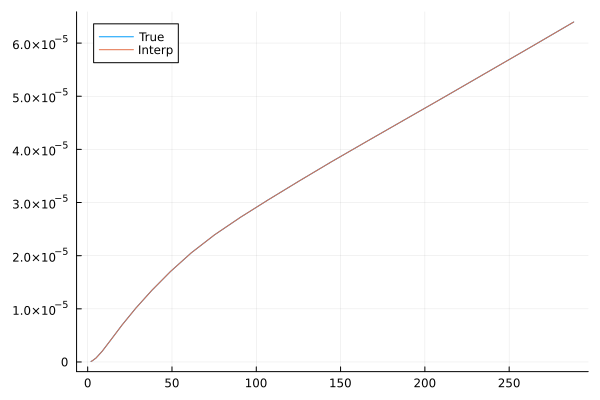

In [97]:
i = 2
j = 2
plot(ℓ, final_Cℓ_LL_B[:,i,j] .* ℓ .* (ℓ.+1), label = "True")
plot!(ℓ, Cℓ_LL_interpolated[:,i,j] .* ℓ .* (ℓ.+1), label = "Interp")

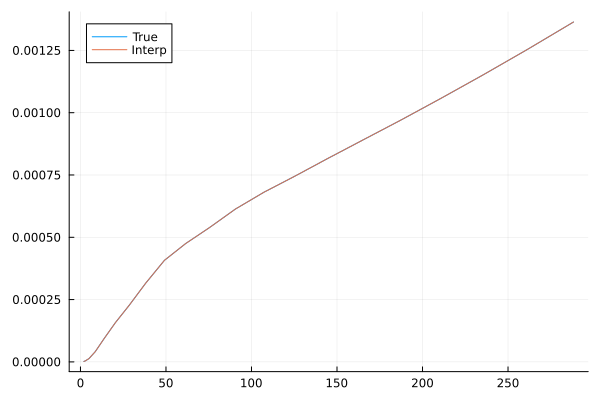

In [98]:
i = 1
j = 1
plot(ℓ, final_Cℓ_CL_B[:,i,j] .* ℓ .* (ℓ.+1), label = "True")
plot!(ℓ, Cℓ_CL_interpolated[:,i,j] .* ℓ .* (ℓ.+1), label = "Interp")

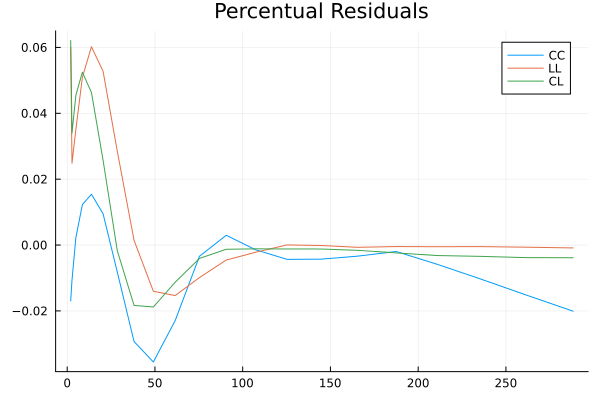

In [99]:
plot(ℓ, 100*(1 .- Cℓ_CC_interpolated[:,i,j]./final_Cℓ_CC_B[:,i,j]), title="Percentual Residuals", label = "CC")
plot!(ℓ, 100*(1 .- Cℓ_LL_interpolated[:,i,j]./final_Cℓ_LL_B[:,i,j]), label="LL")
plot!(ℓ, 100*(1 .- Cℓ_CL_interpolated[:,i,j]./final_Cℓ_CL_B[:,i,j]), label = "CL")

In [100]:
@time σ_CC_int, σ_LL_int, σ_CL_int = cosmic_variance(Cℓ_CC_interpolated, Cℓ_LL_interpolated, Cℓ_CL_interpolated,0.4);

  0.001535 seconds (59 allocations: 33.547 KiB)


In [101]:
@time begin 
    m_CC_int = MAER(Cℓ_CC_interpolated, gg_interp, σ_CC_int)
    m_LL_int = MAER(Cℓ_LL_interpolated, ll_interp, σ_LL_int)
    m_CL_int = MAER(Cℓ_CL_interpolated, gl_interp, σ_CL_int)
end;

  0.000021 seconds (4 allocations: 29.125 KiB)


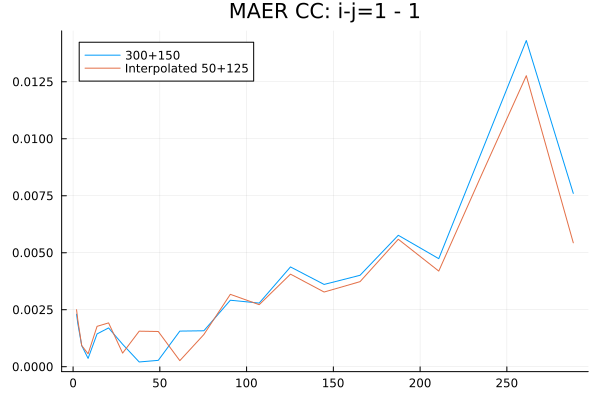

In [102]:
plot(ℓ, m_CC_A[:,i,j], label="300+150", title = "MAER CC: i-j=$i - $j")
plot!(ℓ, m_CC_int[:,i,j], label="Interpolated $n1+$n2")

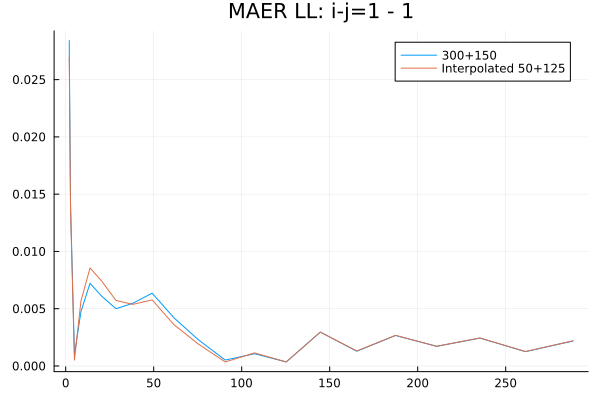

In [103]:
plot(ℓ, m_LL_A[:,i,j], label="300+150", title = "MAER LL: i-j=$i - $j")
plot!(ℓ, m_LL_int[:,i,j], label="Interpolated $n1+$n2")

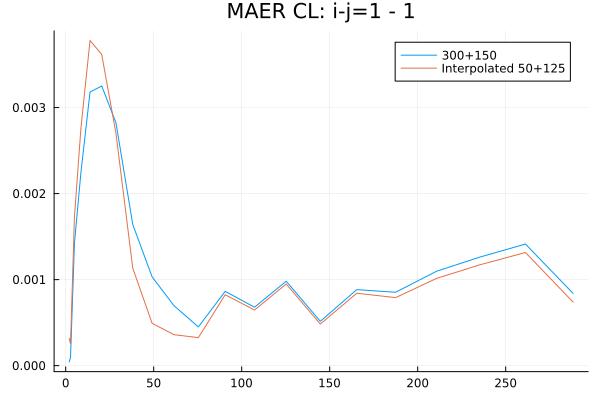

In [104]:
plot(ℓ, m_CL_A[:,i,j], label="300+150", title = "MAER CL: i-j=$i - $j")
plot!(ℓ, m_CL_int[:,i,j], label="Interpolated $n1+$n2")